In [1]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import os
import numpy as np
import matplotlib.pyplot as plt
import math

Using TensorFlow backend.
/home/prakhar/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/prakhar/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/prakhar/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/prakhar/.local/lib/python3.6/site-packages/tensorflow/py

In [2]:
(x_train, _),(_, _) = mnist.load_data()

In [3]:
print(x_train.shape)

(60000, 28, 28)


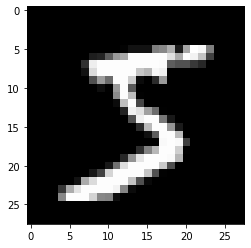

In [4]:
plt.imshow(x_train[0], cmap='gray')
plt.show()

In [5]:
# Normalize data [-1, 1]
x_train = (x_train.astype('float32') - 127.5)/127.5
x_train = x_train.reshape(-1, 784)

print(np.min(x_train))
print(np.max(x_train))
print(x_train.shape)

-1.0
1.0
(60000, 784)


In [6]:
TOTAL_EPOCHS = 50
BATCH_SIZE = 256

NO_OF_BATCHES = int(x_train.shape[0]/BATCH_SIZE)
HALF_BATCH = 128
NOISE_DIM = 100
adam = Adam(lr=2e-4, beta_1=0.5)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# Generator
# Input Noise(100 dim) and outputs vector(784 dim)

generator = Sequential()
generator.add(Dense(256, input_shape=(NOISE_DIM,)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               803600    
Total para

In [8]:
# Downsampling
discriminator = Sequential()
discriminator.add(Dense(512, input_shape=(784,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [9]:
# GAN
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM, ))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

# Functional API
model = Model(gan_input, gan_output)
model.compile(loss='binary_crossentropy', optimizer=adam)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 533505    
Total params: 2,019,857
Trainable params: 1,486,352
Non-trainable params: 533,505
_________________________________________________________________


In [10]:
def makeDir(dirName):
    try:
        os.mkdir(dirName)
        print("Directory " + dirName + " created")
    except FileExistsError:
        print("Directory " + dirName + " already exists")

makeDir('model')
makeDir('images')
    
def save_imgs(epoch, samples=100):
    
    noise = np.random.normal(0, 1, size=(samples, NOISE_DIM))
    generated_imgs = generator.predict(noise)
    generated_imgs = generated_imgs.reshape(samples, 28, 28)
    
    plt.figure(figsize=(10, 10))
    for i in range(samples):
        plt.subplot(10, 10, i+1)
        plt.imshow(generated_imgs[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig('images/gan_output_epoch_{0}.png'.format(epoch+1))
    plt.show()

Directory model already exists
Directory images already exists


Instructions for updating:
Use tf.cast instead.


/home/prakhar/.local/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1 Disc loss 0.6482 Generator loss 0.9354
Epoch 2 Disc loss 0.6480 Generator loss 1.0168
Epoch 3 Disc loss 0.6393 Generator loss 1.0978
Epoch 4 Disc loss 0.6195 Generator loss 1.1539
Epoch 5 Disc loss 0.6084 Generator loss 1.1991


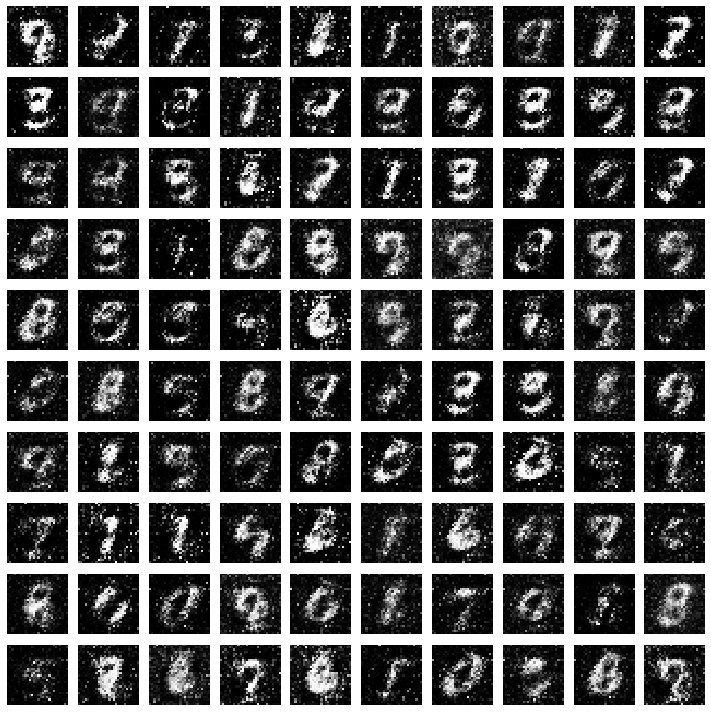

Epoch 6 Disc loss 0.5888 Generator loss 1.2483
Epoch 7 Disc loss 0.5712 Generator loss 1.3064
Epoch 8 Disc loss 0.5767 Generator loss 1.2485
Epoch 9 Disc loss 0.5833 Generator loss 1.2617
Epoch 10 Disc loss 0.6074 Generator loss 1.1488


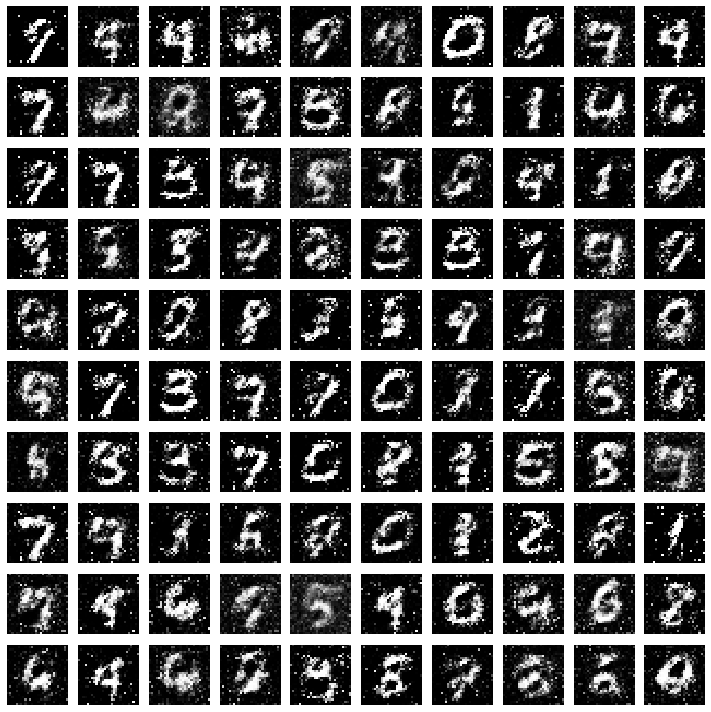

Epoch 11 Disc loss 0.6100 Generator loss 1.1375
Epoch 12 Disc loss 0.6187 Generator loss 1.1165
Epoch 13 Disc loss 0.6300 Generator loss 1.0705
Epoch 14 Disc loss 0.6349 Generator loss 1.0564
Epoch 15 Disc loss 0.6346 Generator loss 1.0483


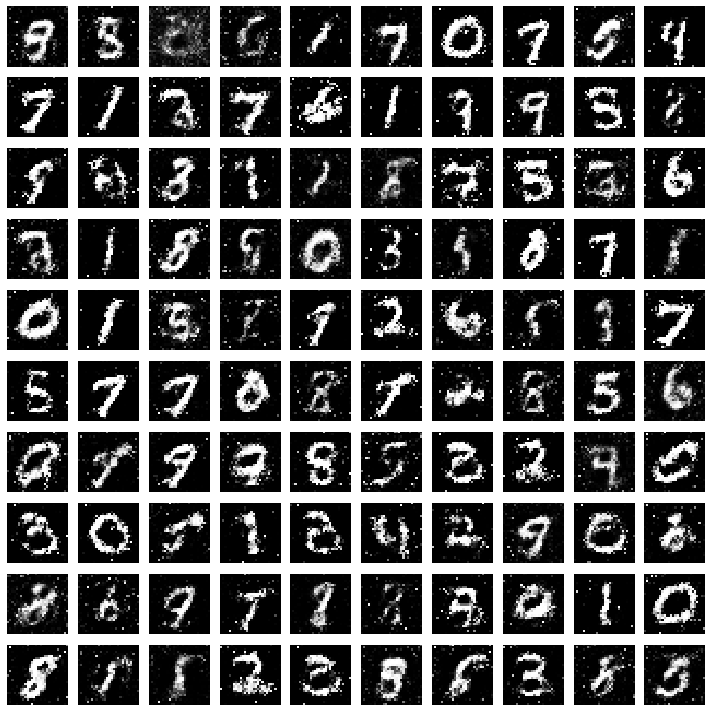

Epoch 16 Disc loss 0.6407 Generator loss 1.0448
Epoch 17 Disc loss 0.6429 Generator loss 1.0399
Epoch 18 Disc loss 0.6480 Generator loss 1.0307
Epoch 19 Disc loss 0.6489 Generator loss 1.0318
Epoch 20 Disc loss 0.6495 Generator loss 1.0230


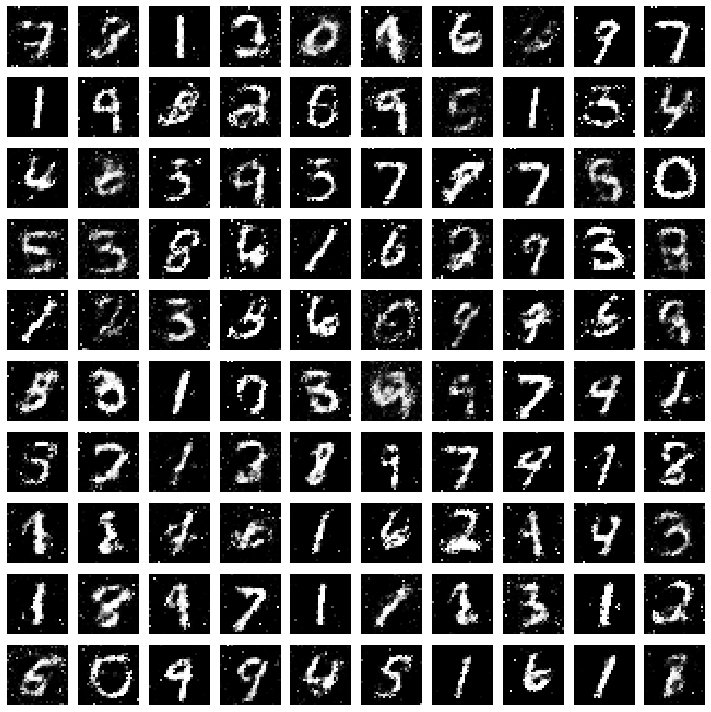

Epoch 21 Disc loss 0.6509 Generator loss 1.0235
Epoch 22 Disc loss 0.6496 Generator loss 1.0170
Epoch 23 Disc loss 0.6512 Generator loss 1.0163
Epoch 24 Disc loss 0.6511 Generator loss 1.0175
Epoch 25 Disc loss 0.6526 Generator loss 1.0150


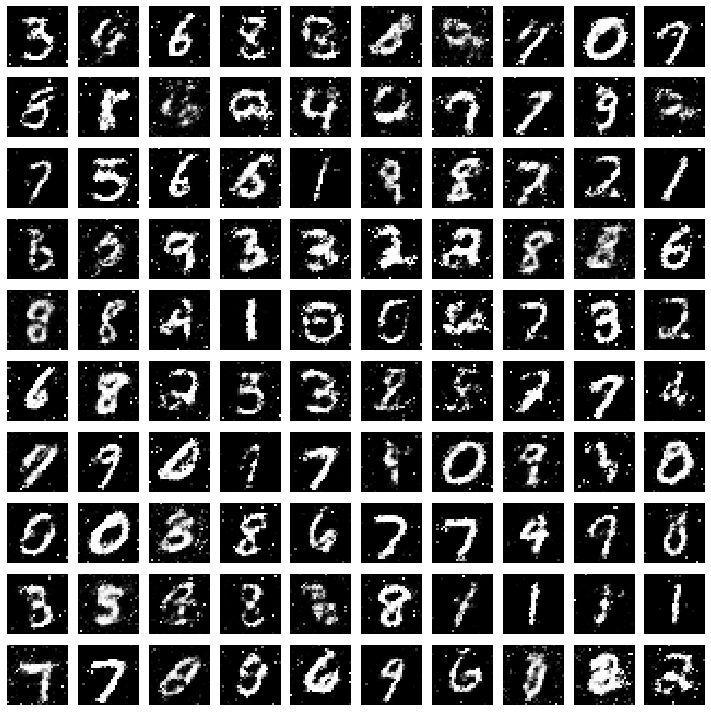

Epoch 26 Disc loss 0.6540 Generator loss 1.0164
Epoch 27 Disc loss 0.6561 Generator loss 1.0028
Epoch 28 Disc loss 0.6576 Generator loss 0.9993
Epoch 29 Disc loss 0.6551 Generator loss 1.0108
Epoch 30 Disc loss 0.6556 Generator loss 1.0058


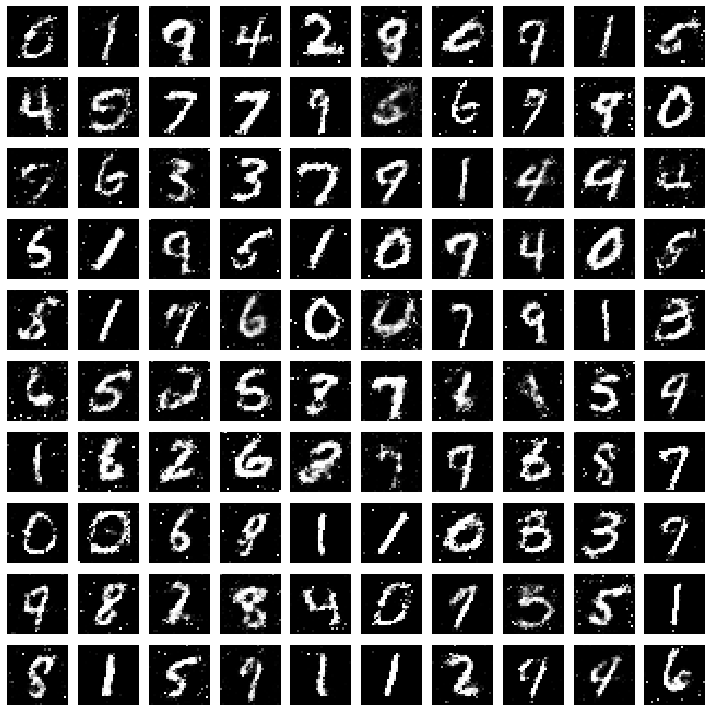

Epoch 31 Disc loss 0.6583 Generator loss 1.0012
Epoch 32 Disc loss 0.6569 Generator loss 1.0022
Epoch 33 Disc loss 0.6583 Generator loss 1.0047
Epoch 34 Disc loss 0.6565 Generator loss 1.0092
Epoch 35 Disc loss 0.6583 Generator loss 1.0049


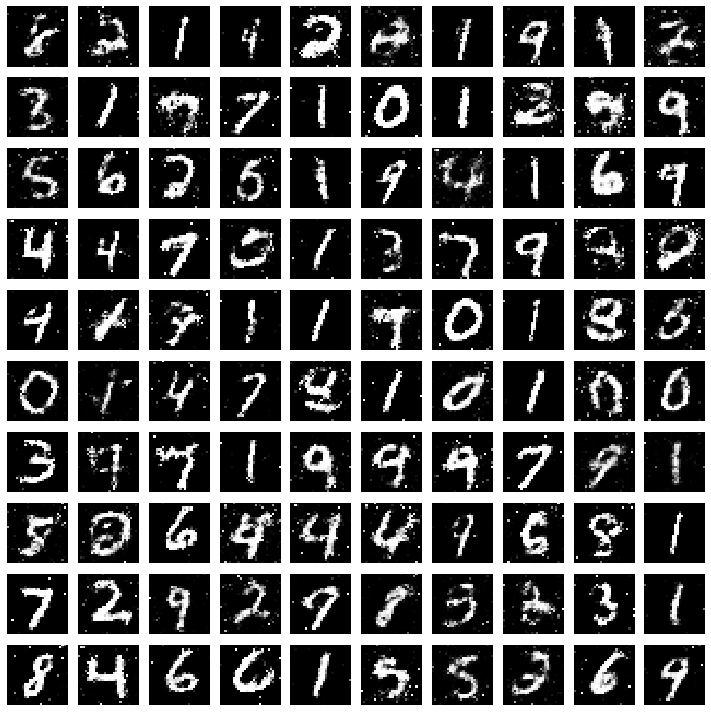

Epoch 36 Disc loss 0.6581 Generator loss 1.0028
Epoch 37 Disc loss 0.6584 Generator loss 1.0069
Epoch 38 Disc loss 0.6585 Generator loss 1.0019
Epoch 39 Disc loss 0.6590 Generator loss 1.0037
Epoch 40 Disc loss 0.6606 Generator loss 1.0018


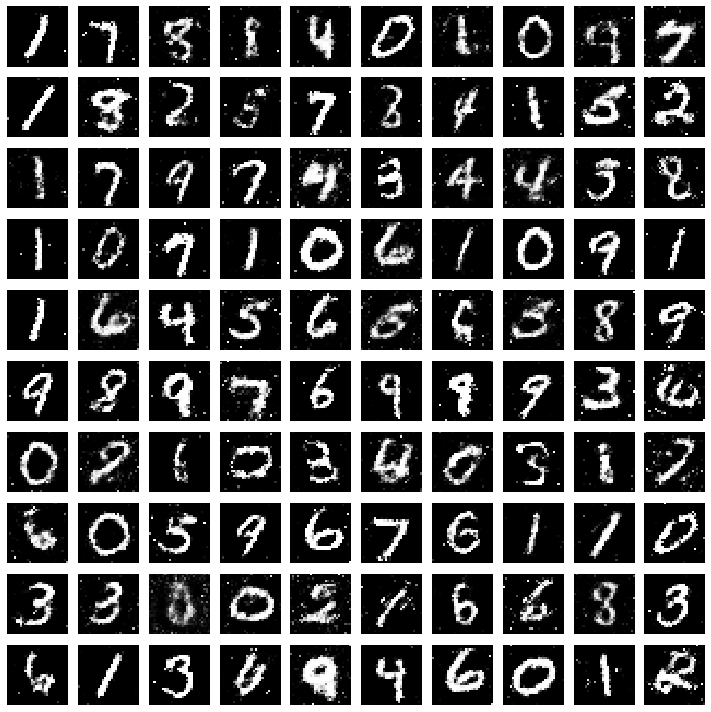

Epoch 41 Disc loss 0.6624 Generator loss 0.9950
Epoch 42 Disc loss 0.6600 Generator loss 1.0012
Epoch 43 Disc loss 0.6611 Generator loss 0.9995
Epoch 44 Disc loss 0.6597 Generator loss 1.0051
Epoch 45 Disc loss 0.6613 Generator loss 0.9992


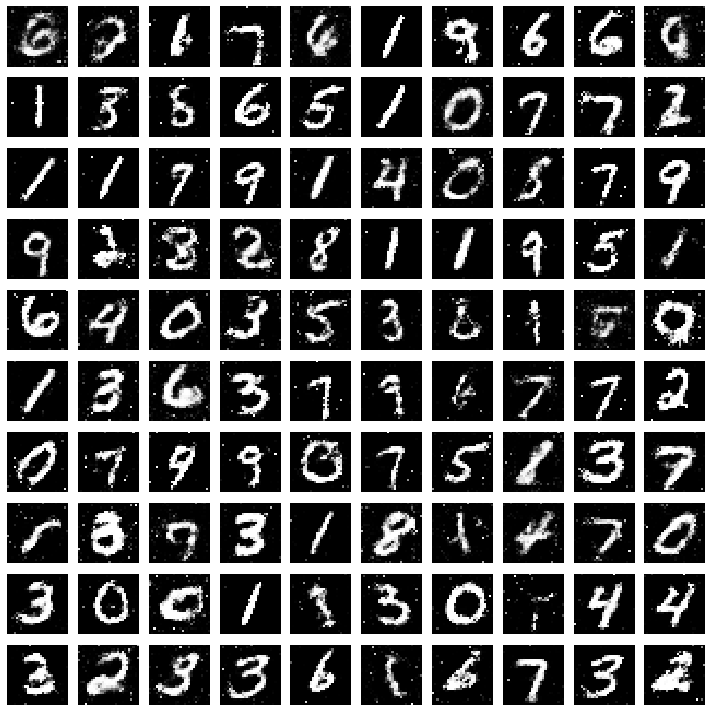

Epoch 46 Disc loss 0.6620 Generator loss 0.9932
Epoch 47 Disc loss 0.6627 Generator loss 0.9895
Epoch 48 Disc loss 0.6632 Generator loss 0.9963
Epoch 49 Disc loss 0.6642 Generator loss 0.9912
Epoch 50 Disc loss 0.6643 Generator loss 0.9918


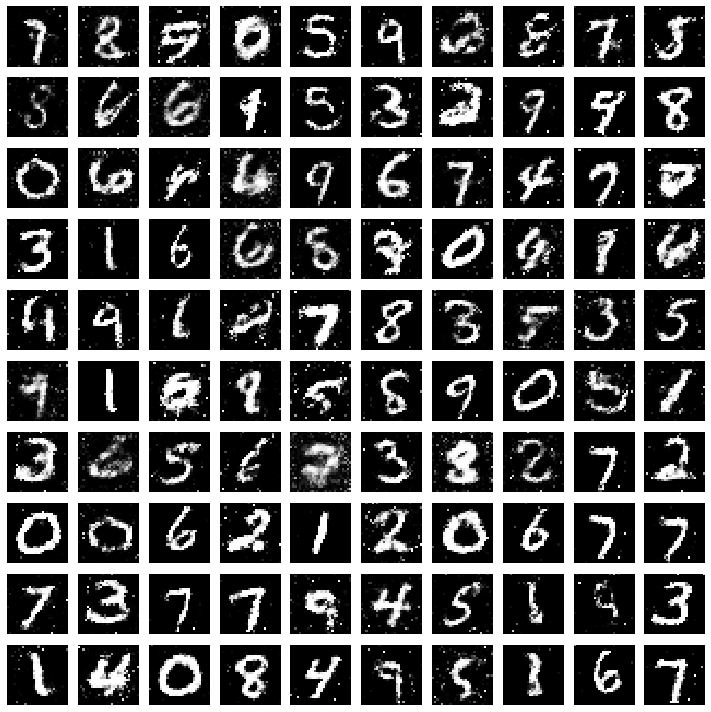

In [11]:
# Training loop

for epoch in range(TOTAL_EPOCHS):
    epoch_d_loss = 0
    epoch_g_loss = 0
    
    #Mini batch SGD
    for step in range(NO_OF_BATCHES):
        
        # Step-1 Discriminator
        # 50% real data + 50% fake data
        
        # Real data
        idx = np.random.randint(0, x_train.shape[0], HALF_BATCH)
        real_imgs = x_train[idx]
            
        # fake data
        noise = np.random.normal(0, 1, size=(HALF_BATCH, NOISE_DIM))
        fake_imgs = generator.predict(noise) # Forward
        
        # Labels
        real_y = np.ones((HALF_BATCH, 1))*0.9
        fake_y = np.zeros((HALF_BATCH, 1))
        
        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)
        d_loss = 0.5*d_loss_fake + 0.5*d_loss_real
        
        epoch_d_loss += d_loss
        
        # Train Generator(Considering Discriminator frozen)
        noise = np.random.normal(0, 1, size=(BATCH_SIZE, NOISE_DIM))
        ground_truth_y = np.ones((BATCH_SIZE, 1))
        g_loss = model.train_on_batch(noise, ground_truth_y)
        
        epoch_g_loss += g_loss
    

    print("Epoch %d Disc loss %.4f Generator loss %.4f"%((epoch+1), epoch_d_loss/NO_OF_BATCHES, epoch_g_loss/NO_OF_BATCHES))
    
    if (epoch+1)%5==0:
        generator.save('model/gan_generator_{0}.h5'.format(epoch+1))
        save_imgs(epoch)
        